In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/food11/validation/8_248.jpg
/kaggle/input/food11/validation/5_365.jpg
/kaggle/input/food11/validation/8_210.jpg
/kaggle/input/food11/validation/5_0.jpg
/kaggle/input/food11/validation/9_104.jpg
/kaggle/input/food11/validation/0_307.jpg
/kaggle/input/food11/validation/3_200.jpg
/kaggle/input/food11/validation/5_59.jpg
/kaggle/input/food11/validation/2_245.jpg
/kaggle/input/food11/validation/9_276.jpg
/kaggle/input/food11/validation/8_209.jpg
/kaggle/input/food11/validation/2_178.jpg
/kaggle/input/food11/validation/9_85.jpg
/kaggle/input/food11/validation/9_161.jpg
/kaggle/input/food11/validation/4_316.jpg
/kaggle/input/food11/validation/0_249.jpg
/kaggle/input/food11/validation/4_122.jpg
/kaggle/input/food11/validation/9_403.jpg
/kaggle/input/food11/validation/0_217.jpg
/kaggle/input/food11/validation/3_193.jpg
/kaggle/input/food11/validation/2_374.jpg
/kaggle/input/food11/validation/5_376.jpg
/kaggle/input/food11/validation/0_354.jpg
/kaggle/input/food11/validation/0_287.

### Importing the libraries

In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset ,DataLoader
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train_dir="/kaggle/input/food11/training"
test_dir="/kaggle/input/food11/evaluation"
val_dir="/kaggle/input/food11/validation"
img_size=(224,224)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
class food(Dataset):
    def __init__(self,images,img_size,transform=None):
        super().__init__()
        self.img_size=img_size
        self.l=[]
        self.images=images
        self.transform = transform
        for i in os.listdir(self.images):
            if(i[1]!='_'):
                self.l.append((os.path.join(self.images,i),int(i[0]+i[1])))
            else:
                self.l.append((os.path.join(self.images,i),int(i[0])))



    def __len__(self):
        
        return len((self.l))

    def __getitem__(self, idx):
        img_path, label = self.l[idx]
        img = Image.open(img_path).convert('RGB')  # Ensure PIL image
        img = img.resize(self.img_size)  # Resize using PIL
        
        if self.transform:
            img = self.transform(img)  # Apply transformations (expects PIL or tensor)
        else:
            img = torch.tensor(np.array(img) / 255.0, dtype=torch.float32).permute(2, 0, 1)  

        return img, label

        

In [5]:
train_set=food("/kaggle/input/food11/training",img_size) #,transform=transform)
val_set=food("/kaggle/input/food11/evaluation",img_size)
test_set=food("/kaggle/input/food11/validation",img_size)
train_dataloader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=4)
val_dataloader=DataLoader(val_set,batch_size=8,shuffle=False,num_workers=4)
print(len(train_set))
print(len(test_set))
print(len(val_set))

9866
3430
3347


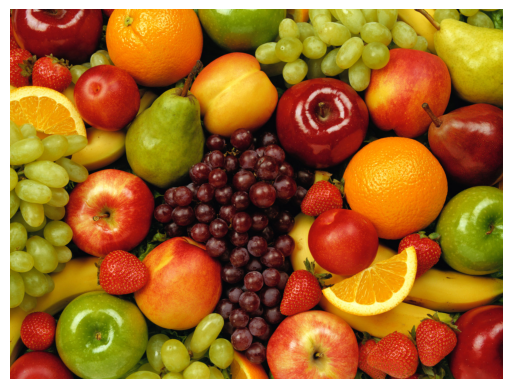

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
img = Image.open('/kaggle/input/food11/evaluation/10_112.jpg')

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Optionally hide axis
plt.show()

In [10]:
class Resnet18(nn.Module):
    def __init__(self,out_classes):
        super(Resnet18,self).__init__()

        self.relu=nn.ReLU()
        self.dropoutp = 0.5
        #conv1
        self.conv11=nn.Conv2d(3,64,kernel_size=(7,7),stride=(2,2),padding=(3,3))
        self.batchnorm1=nn.BatchNorm2d(64)
        self.maxpool1=nn.MaxPool2d((3,3),stride=(2,2),padding=(1,1))
         

        # BLOCK-2(1) input=(56x56) output=(56x56)
        
        self.conv211=nn.Conv2d(64,64,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.batchnorm211=nn.BatchNorm2d(64)
        self.conv212=nn.Conv2d(64,64,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.batchnorm212=nn.BatchNorm2d(64)
        self.dropout21=nn.Dropout(p=self.dropoutp)
        # BLOCK-2(2) 
        self.conv221=nn.Conv2d(64,64,kernel_size=(3,3),stride=(1,1),padding=(1,1))        
        self.batchnorm221=nn.BatchNorm2d(64)
        self.conv222=nn.Conv2d(64,64,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.batchnorm222=nn.BatchNorm2d(64)
        self.dropout22=nn.Dropout(p=self.dropoutp)

        # BLOCK-3(1) input=(56x56) output=(28x28)
        self.conv311=nn.Conv2d(64,128,kernel_size=(3,3),stride=(2,2),padding=(1,1))
        self.batchnorm311=nn.BatchNorm2d(128)
        self.conv312=nn.Conv2d(128,128,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.batchnorm312=nn.BatchNorm2d(128)
        self.dropout31=nn.Dropout(p=self.dropoutp)
        self.concat_adjust31=nn.Conv2d(64,128,kernel_size=(1,1),stride=(2,2),padding=(0,0))
        #BLOCK-3(2)
        self.conv321=nn.Conv2d(128,128,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.batchnorm321=nn.BatchNorm2d(128)
        self.conv322=nn.Conv2d(128,128,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.batchnorm322=nn.BatchNorm2d(128)
        self.dropout32=nn.Dropout(p=self.dropoutp)

        #BLOCK-4(1)input=(28x28) ouput=(14x14)
        self.conv411=nn.Conv2d(128,256,kernel_size=(3,3),stride=(2,2),padding=(1,1))
        self.batchnorm411=nn.BatchNorm2d(256)
        self.conv412=nn.Conv2d(256,256,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.batchnorm412=nn.BatchNorm2d(256)
        self.dropout41=nn.Dropout(p=self.dropoutp)
        self.concat_adjust41=nn.Conv2d(128,256,kernel_size=(1,1),stride=(2,2),padding=(0,0))

        #BLOCK-4(2)
        self.conv421=nn.Conv2d(256,256,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.batchnorm421=nn.BatchNorm2d(256)
        self.conv422=nn.Conv2d(256,256,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.batchnorm422=nn.BatchNorm2d(256)
        self.dropout42=nn.Dropout(p=self.dropoutp)

        #BLOCK-5(1) input=(14x14)  output=(7x7)
        self.conv511=nn.Conv2d(256,512,kernel_size=(3,3),stride=(2,2),padding=(1,1))
        self.batchnorm511=nn.BatchNorm2d(512)
        self.conv512=nn.Conv2d(512,512,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.batchnorm512=nn.BatchNorm2d(512)
        self.dropout51=nn.Dropout(p=self.dropoutp)
        self.concat_adjust51=nn.Conv2d(256,512,kernel_size=(1,1),stride=(2,2),padding=(0,0))

        #BLOCK-5(2)
        self.conv521=nn.Conv2d(512,512,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.batchnorm521=nn.BatchNorm2d(512)
        self.conv522=nn.Conv2d(512,512,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.batchnorm522=nn.BatchNorm2d(512)
        self.dropout52=nn.Dropout(p=self.dropoutp)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc=nn.Linear(512,1000)
        self.out=nn.Linear(1000,out_classes)



    def forward(self,x):
        x=self.relu(self.batchnorm1(self.conv11(x)))
        x11=self.maxpool1(x)
        
        #block2-1
        x=self.conv211(x11)
        x=self.batchnorm211(x)
        x=self.relu(x)
        x=self.conv212(x)
        x=self.batchnorm212(x)
        x=self.dropout21(x)
        x21=self.relu(x+x11)
                  
        #block2-2
        x=self.conv221(x21)
        x=self.batchnorm221(x)
        x=self.relu(x)
        x=self.conv222(x)
        x=self.batchnorm222(x)
        x=self.dropout22(x)
        x22=self.relu(x21+x)


        #block3-1
        x=self.conv311(x22)
        x=self.batchnorm311(x)
        x=self.relu(x)
        x=self.conv312(x)
        x=self.batchnorm312(x)
        x=self.dropout31(x)
        
        x22=self.concat_adjust31(x22)
        x31=self.relu(x+x22)

        #block3-2
        x=self.conv321(x31)
        x=self.batchnorm321(x)
        x=self.relu(x)
        x=self.conv322(x)
        x=self.batchnorm322(x)
        x=self.dropout32(x)
        
        x32=self.relu(x+x31)
  
        #block4-1
        x=self.conv411(x32)
        x=self.batchnorm411(x)
        x=self.relu(x)
        x=self.conv412(x)
        x=self.batchnorm412(x)
        x=self.dropout41(x)
        
        x32=self.concat_adjust41(x32)
        x41=self.relu((x+x32))

        #block4-2
        x=self.conv421(x41)
        x=self.batchnorm421(x)
        x=self.relu(x)
        x=self.conv422(x)
        x=self.batchnorm422(x)
        x=self.dropout42(x)
        
        x42=self.relu(x+x41)


        #block5-1
        x=self.conv511(x42)
        x=self.batchnorm511(x)
        x=self.relu(x)
        x=self.conv512(x)
        x=self.batchnorm512(x)
        x=self.dropout51(x)

        x42=self.concat_adjust51(x42)
        x51=self.relu(x+x42)

        #block5-2
        x=self.conv521(x51)
        x=self.batchnorm521(x)
        x=self.relu(x)
        x=self.conv522(x)
        x=self.batchnorm522(x)
        x=self.dropout52(x)
        
        x52=self.relu(x+x51)
        
        
        #linear block
        x=self.avgpool(x52)
        #print(x.shape)
        x= x.reshape(x.shape[0],-1)        
        x=self.fc(x)
        x=self.relu(x)
        x=self.out(x)

        return x

        

In [11]:
model=Resnet18(11)
model.to(device)

Resnet18(
  (relu): ReLU()
  (conv11): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (conv211): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm211): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv212): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm212): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout21): Dropout(p=0.5, inplace=False)
  (conv221): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm221): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv222): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm222): BatchNorm2d(64, eps=1e-

In [12]:
from torchinfo import summary

In [13]:
summary(model=model, input_size=(8, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Resnet18                                 [8, 3, 224, 224]          [8, 11]                   --                        True
├─Conv2d: 1-1                            [8, 3, 224, 224]          [8, 64, 112, 112]         9,472                     True
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]         [8, 64, 112, 112]         128                       True
├─ReLU: 1-3                              [8, 64, 112, 112]         [8, 64, 112, 112]         --                        --
├─MaxPool2d: 1-4                         [8, 64, 112, 112]         [8, 64, 56, 56]           --                        --
├─Conv2d: 1-5                            [8, 64, 56, 56]           [8, 64, 56, 56]           36,928                    True
├─BatchNorm2d: 1-6                       [8, 64, 56, 56]           [8, 64, 56, 56]           128                       True
├─ReLU:

In [14]:
pip install --upgrade calflops

Note: you may need to restart the kernel to use updated packages.


In [15]:
from calflops import calculate_flops
from torchvision import models


batch_size = 1
input_shape = (batch_size, 3, 224, 224)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  11.7 M  
fwd MACs:                                                               1.8141 GMACs
fwd FLOPs:                                                              3.6384 GFLOPS
fwd+bwd MACs:                                                           5.4423 GMACs
fwd+bwd FLOPs:                                                          10.9152 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each modul

In [16]:
from torch.optim import Adam
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)


In [17]:
import torch
from tqdm import tqdm

train_loss_score=[]
test_loss_score=[]
torch.manual_seed(40)
num_epochs = 24
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training loop
    for X, Y in tqdm(train_dataloader, total=len(train_dataloader), leave=False):
        optimizer.zero_grad()
        X = X.to(device).float()
        Y = Y.to(device)
        
        # Forward pass
        outputs = model(X)
        
  
        targets = Y
       
       
        # Compute loss
        loss = criterion(outputs, targets)
       
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() 
    
    epoch_loss = running_loss / len(train_dataloader.dataset)
    train_loss_score.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for X_test, Y_test in tqdm(test_dataloader, total=len(test_dataloader), leave=False):
            X_test = X_test.to(device).float()
            Y_test = Y_test.to(device)
            
            # Forward pass
            outputs_test = model(X_test)
            
           
            targets_test = Y_test
            
            # Compute loss
            test_loss += criterion(outputs_test, targets_test).item()
            
    test_loss /= len(test_dataloader.dataset)
    test_loss_score.append(test_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}')
    

print("Training  complete!")

Epoch [1/24], Training Loss: 0.2562


Epoch [1/24], Test Loss: 0.2318


Epoch [2/24], Training Loss: 0.2338


Epoch [2/24], Test Loss: 0.2673


Epoch [3/24], Training Loss: 0.2186


Epoch [3/24], Test Loss: 0.2259


Epoch [4/24], Training Loss: 0.2053


Epoch [4/24], Test Loss: 0.2006


Epoch [5/24], Training Loss: 0.1927


Epoch [5/24], Test Loss: 0.2278


Epoch [6/24], Training Loss: 0.1816


Epoch [6/24], Test Loss: 0.1848


Epoch [7/24], Training Loss: 0.1687


Epoch [7/24], Test Loss: 0.1912


Epoch [8/24], Training Loss: 0.1597


Epoch [8/24], Test Loss: 0.1726


Epoch [9/24], Training Loss: 0.1510


Epoch [9/24], Test Loss: 0.1967


Epoch [10/24], Training Loss: 0.1428


Epoch [10/24], Test Loss: 0.1579


Epoch [11/24], Training Loss: 0.1348


Epoch [11/24], Test Loss: 0.1630


Epoch [12/24], Training Loss: 0.1270


Epoch [12/24], Test Loss: 0.1405


Epoch [13/24], Training Loss: 0.1210


Epoch [13/24], Test Loss: 0.1652


Epoch [14/24], Training Loss: 0.1137


Epoch [14/24], Test Loss: 0.1750


Epoch [15/24], Training Loss: 0.1084


Epoch [15/24], Test Loss: 0.1602


Epoch [16/24], Training Loss: 0.1013


Epoch [16/24], Test Loss: 0.1436


Epoch [17/24], Training Loss: 0.0966


Epoch [17/24], Test Loss: 0.1540


Epoch [18/24], Training Loss: 0.0883


Epoch [18/24], Test Loss: 0.1331


Epoch [19/24], Training Loss: 0.0829


Epoch [19/24], Test Loss: 0.2176


Epoch [20/24], Training Loss: 0.0773


Epoch [20/24], Test Loss: 0.1393


Epoch [21/24], Training Loss: 0.0715


Epoch [21/24], Test Loss: 0.1573


Epoch [22/24], Training Loss: 0.0676


Epoch [22/24], Test Loss: 0.1561


Epoch [23/24], Training Loss: 0.0602


Epoch [23/24], Test Loss: 0.1935


Epoch [24/24], Training Loss: 0.0589


Epoch [24/24], Test Loss: 0.1781
Training  complete!


## Training and Test loss visualisation


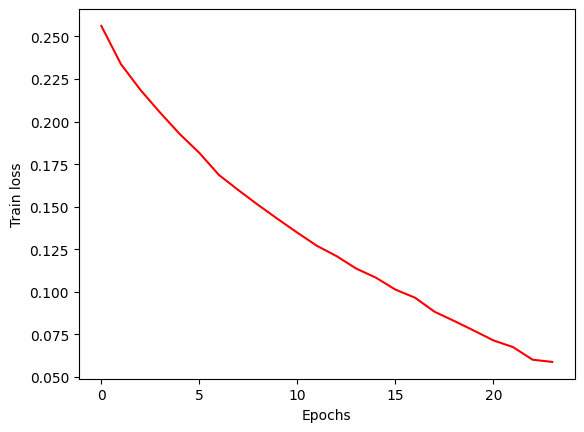

In [18]:
plt.plot(train_loss_score,color='red')
plt.xlabel("Epochs")
plt.ylabel("Train loss")
plt.show()

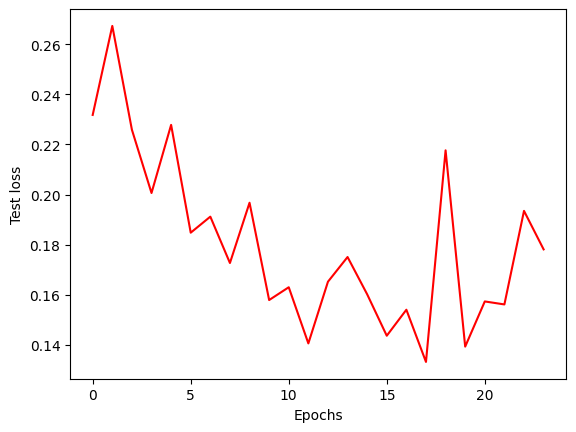

In [19]:
plt.plot(test_loss_score,color='red')
plt.xlabel("Epochs")
plt.ylabel("Test loss")
plt.show()

In [20]:
pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [21]:
from torcheval.metrics import MulticlassAccuracy
metric = MulticlassAccuracy(num_classes=11)

In [22]:
model.eval()
with torch.no_grad():  
    for x_batch, y_batch in val_dataloader:
        
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            
        outputs = model(x_batch)
    
       
        predictions = torch.argmax(outputs, dim=1)
        metric.update(predictions, y_batch)

# Compute final accuracy
accuracy = metric.compute()
print(f"Overall Accuracy: {accuracy.item():.4f}")

Overall Accuracy: 0.6391


In [23]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

class_names = [
    "Bread", "Dairy product", "Dessert", "Egg", "Fried food",
    "Meat", "Noodles/Pasta", "Rice", "Seafood", "Soup", "Vegetable/Fruit"
]


num_classes = len(class_names)


softmax = nn.Softmax(dim=1)


all_true_labels = []
all_pred_labels = []

model.eval()  


with torch.no_grad():  
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device) 
        labels = labels.to(device)  
        
        outputs = model(inputs)
        
        predicted = softmax(outputs).argmax(dim=1)  
        
        
        all_true_labels.extend(labels.cpu().numpy())
        all_pred_labels.extend(predicted.cpu().numpy())


all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)


cm = confusion_matrix(all_true_labels, all_pred_labels, labels=np.arange(num_classes))
print("Confusion Matrix:")
print(cm)


precision = precision_score(all_true_labels, all_pred_labels, average=None, labels=np.arange(num_classes), zero_division=0)
recall = recall_score(all_true_labels, all_pred_labels, average=None, labels=np.arange(num_classes), zero_division=0)
f1 = f1_score(all_true_labels, all_pred_labels, average=None, labels=np.arange(num_classes), zero_division=0)


print("\nClass-wise Metrics:")
for i in range(num_classes):
    print(f"{class_names[i]:<15} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-score: {f1[i]:.4f}")


precision_avg = precision_score(all_true_labels, all_pred_labels, average='weighted', labels=np.arange(num_classes), zero_division=0)
recall_avg = recall_score(all_true_labels, all_pred_labels, average='weighted', labels=np.arange(num_classes), zero_division=0)
f1_avg = f1_score(all_true_labels, all_pred_labels, average='weighted', labels=np.arange(num_classes), zero_division=0)

print("\nOverall Metrics:")
print(f"Average Precision: {precision_avg:.4f}")
print(f"Average Recall: {recall_avg:.4f}")
print(f"Average F1 Score: {f1_avg:.4f}")


Confusion Matrix:
[[164  58   5  67  19  13   4   3  12  20   3]
 [  2 124   2   3   1   4   0   5   3   1   3]
 [ 26 151 149  40  10  46   2   2  23  39  12]
 [ 20  35   3 260   1   3   1   2   3   5   2]
 [ 11  49   4  12 175  17   0   1   5   9   4]
 [ 16  29   7  23  19 309   0   2  14  11   2]
 [  6   0   0  21   1   3  77  16   0  22   1]
 [ 10   0   0   3   2   3   7  63   0   8   0]
 [  3  62  14   9   3  11   0   1 185  14   1]
 [  2  23   3   7   3   3   2   1   3 453   0]
 [  3   9   9  10   1   2   0   2  12   3 180]]

Class-wise Metrics:
Bread           - Precision: 0.6236, Recall: 0.4457, F1-score: 0.5198
Dairy product   - Precision: 0.2296, Recall: 0.8378, F1-score: 0.3605
Dessert         - Precision: 0.7602, Recall: 0.2980, F1-score: 0.4282
Egg             - Precision: 0.5714, Recall: 0.7761, F1-score: 0.6582
Fried food      - Precision: 0.7447, Recall: 0.6098, F1-score: 0.6705
Meat            - Precision: 0.7464, Recall: 0.7153, F1-score: 0.7305
Noodles/Pasta   - Preci

# Transfer learning on same dataset

In [24]:
import torchvision


In [25]:
weights=torchvision.models.ResNet18_Weights.DEFAULT
model1=torchvision.models.resnet18(weights=weights)
model1.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:


summary(model=model1, input_size=(8, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [8, 3, 224, 224]          [8, 1000]                 --                        True
├─Conv2d: 1-1                            [8, 3, 224, 224]          [8, 64, 112, 112]         9,408                     True
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]         [8, 64, 112, 112]         128                       True
├─ReLU: 1-3                              [8, 64, 112, 112]         [8, 64, 112, 112]         --                        --
├─MaxPool2d: 1-4                         [8, 64, 112, 112]         [8, 64, 56, 56]           --                        --
├─Sequential: 1-5                        [8, 64, 56, 56]           [8, 64, 56, 56]           --                        True
│    └─BasicBlock: 2-1                   [8, 64, 56, 56]           [8, 64, 56, 56]           --                        True
│    │ 

In [27]:
model1.fc

Linear(in_features=512, out_features=1000, bias=True)

In [28]:
for param in model1.parameters():
    param.requires_grad = False  # Freeze feature extractor (Conv layers)


in_features = model1.fc.in_features  


model1.fc = nn.Sequential(
    nn.Linear(in_features, 11)
)

In [29]:
model1.fc

Sequential(
  (0): Linear(in_features=512, out_features=11, bias=True)
)

In [30]:


summary(model=model1, input_size=(8, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [8, 3, 224, 224]          [8, 11]                   --                        Partial
├─Conv2d: 1-1                            [8, 3, 224, 224]          [8, 64, 112, 112]         (9,408)                   False
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]         [8, 64, 112, 112]         (128)                     False
├─ReLU: 1-3                              [8, 64, 112, 112]         [8, 64, 112, 112]         --                        --
├─MaxPool2d: 1-4                         [8, 64, 112, 112]         [8, 64, 56, 56]           --                        --
├─Sequential: 1-5                        [8, 64, 56, 56]           [8, 64, 56, 56]           --                        False
│    └─BasicBlock: 2-1                   [8, 64, 56, 56]           [8, 64, 56, 56]           --                        False


In [31]:
from torch.optim import Adam
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model1.parameters(), lr=0.0001)


In [32]:
import torch
from tqdm import tqdm

train_loss_score=[]
test_loss_score=[]
torch.manual_seed(40)
num_epochs = 15
for epoch in range(num_epochs):
    model1.train()
    running_loss = 0.0
    
    # Training loop
    for X, Y in tqdm(train_dataloader, total=len(train_dataloader), leave=False):
        optimizer.zero_grad()
        X = X.to(device).float()
        Y = Y.to(device)
        
        # Forward pass
        outputs = model1(X)
        
  
        targets = Y
       
       
        # Compute loss
        loss = criterion(outputs, targets)
       
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() 
    
    epoch_loss = running_loss / len(train_dataloader.dataset)
    train_loss_score.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')
    model1.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for X_test, Y_test in tqdm(test_dataloader, total=len(test_dataloader), leave=False):
            X_test = X_test.to(device).float()
            Y_test = Y_test.to(device)
            
            # Forward pass
            outputs_test = model1(X_test)
            
           
            targets_test = Y_test
            
            # Compute loss
            test_loss += criterion(outputs_test, targets_test).item()
            
    test_loss /= len(test_dataloader.dataset)
    test_loss_score.append(test_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}')
    

print("Training  complete!")

Epoch [1/15], Training Loss: 0.2329


Epoch [1/15], Test Loss: 0.1752


Epoch [2/15], Training Loss: 0.1700


Epoch [2/15], Test Loss: 0.1330


Epoch [3/15], Training Loss: 0.1438


Epoch [3/15], Test Loss: 0.1149


Epoch [4/15], Training Loss: 0.1297


Epoch [4/15], Test Loss: 0.1105


Epoch [5/15], Training Loss: 0.1224


Epoch [5/15], Test Loss: 0.1023


Epoch [6/15], Training Loss: 0.1178


Epoch [6/15], Test Loss: 0.0959


Epoch [7/15], Training Loss: 0.1126


Epoch [7/15], Test Loss: 0.0964


Epoch [8/15], Training Loss: 0.1090


Epoch [8/15], Test Loss: 0.0950


Epoch [9/15], Training Loss: 0.1068


Epoch [9/15], Test Loss: 0.0926


Epoch [10/15], Training Loss: 0.1044


Epoch [10/15], Test Loss: 0.0892


Epoch [11/15], Training Loss: 0.1020


Epoch [11/15], Test Loss: 0.0882


Epoch [12/15], Training Loss: 0.1005


Epoch [12/15], Test Loss: 0.0882


Epoch [13/15], Training Loss: 0.1010


Epoch [13/15], Test Loss: 0.0875


Epoch [14/15], Training Loss: 0.0978


Epoch [14/15], Test Loss: 0.0865


Epoch [15/15], Training Loss: 0.0979


Epoch [15/15], Test Loss: 0.0874
Training  complete!


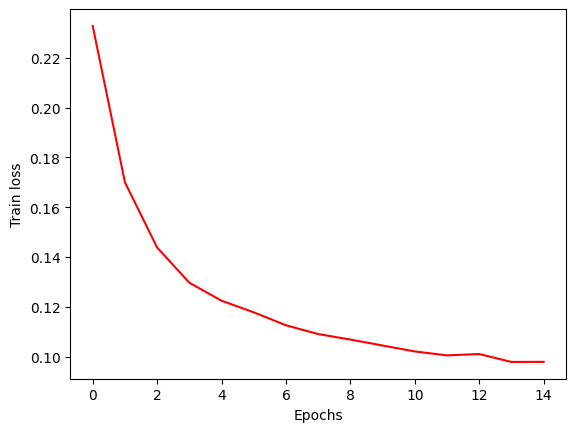

In [33]:
plt.plot(train_loss_score,color='red')
plt.xlabel("Epochs")
plt.ylabel("Train loss")
plt.show()

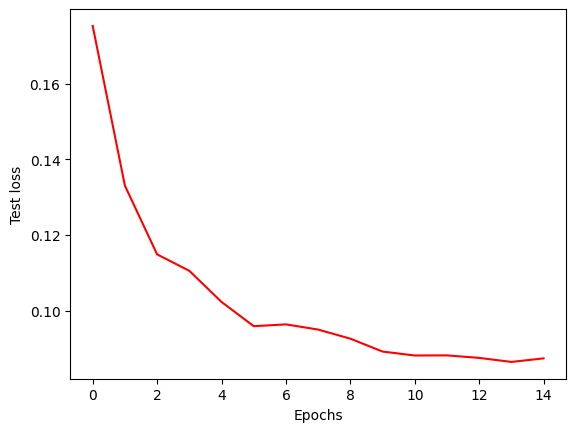

In [34]:
plt.plot(test_loss_score,color='red')
plt.xlabel("Epochs")
plt.ylabel("Test loss")
plt.show()

In [39]:
model.eval()
with torch.no_grad():  
    for x_batch, y_batch in val_dataloader:
        
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            
        outputs = model1(x_batch)
    
       
        predictions = torch.argmax(outputs, dim=1)
        metric.update(predictions, y_batch)

# Compute final accuracy
accuracy = metric.compute()
print(f"Overall Accuracy: {accuracy.item():.4f}")

Overall Accuracy: 0.7727


In [40]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

class_names = [
    "Bread", "Dairy product", "Dessert", "Egg", "Fried food",
    "Meat", "Noodles/Pasta", "Rice", "Seafood", "Soup", "Vegetable/Fruit"
]


num_classes = len(class_names)


softmax = nn.Softmax(dim=1)


all_true_labels = []
all_pred_labels = []

model.eval()  


with torch.no_grad():  
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device) 
        labels = labels.to(device)  
        
        outputs = model1(inputs)
        
        predicted = softmax(outputs).argmax(dim=1)  
        
        
        all_true_labels.extend(labels.cpu().numpy())
        all_pred_labels.extend(predicted.cpu().numpy())


all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)


cm = confusion_matrix(all_true_labels, all_pred_labels, labels=np.arange(num_classes))
print("Confusion Matrix:")
print(cm)


precision = precision_score(all_true_labels, all_pred_labels, average=None, labels=np.arange(num_classes), zero_division=0)
recall = recall_score(all_true_labels, all_pred_labels, average=None, labels=np.arange(num_classes), zero_division=0)
f1 = f1_score(all_true_labels, all_pred_labels, average=None, labels=np.arange(num_classes), zero_division=0)


print("\nClass-wise Metrics:")
for i in range(num_classes):
    print(f"{class_names[i]:<15} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-score: {f1[i]:.4f}")

# Compute and print overall (weighted) metrics
precision_avg = precision_score(all_true_labels, all_pred_labels, average='weighted', labels=np.arange(num_classes), zero_division=0)
recall_avg = recall_score(all_true_labels, all_pred_labels, average='weighted', labels=np.arange(num_classes), zero_division=0)
f1_avg = f1_score(all_true_labels, all_pred_labels, average='weighted', labels=np.arange(num_classes), zero_division=0)

print("\nOverall Metrics:")
print(f"Average Precision: {precision_avg:.4f}")
print(f"Average Recall: {recall_avg:.4f}")
print(f"Average F1 Score: {f1_avg:.4f}")


Confusion Matrix:
[[245   8  39  24  27  10   0   2   7   5   1]
 [  1  87  34   3   1   4   2   1  11   3   1]
 [  7  14 398  14  11  15   2   2  19  16   2]
 [ 33   6  29 231   5   9   2   3  12   4   1]
 [  8   4  19   6 222   9   3   6   5   5   0]
 [  9   2  32   5  16 332   0   5  26   4   1]
 [  0   0   1   1   0   0 140   0   2   3   0]
 [  0   0   4   0   0   1   3  86   0   1   1]
 [  2   5  20   4   0   6   1   1 256   2   6]
 [  2   1  14   1   1   0   1   1  12 466   1]
 [  0   1  10   2   0   3   3   1  17   0 194]]

Class-wise Metrics:
Bread           - Precision: 0.7980, Recall: 0.6658, F1-score: 0.7259
Dairy product   - Precision: 0.6797, Recall: 0.5878, F1-score: 0.6304
Dessert         - Precision: 0.6633, Recall: 0.7960, F1-score: 0.7236
Egg             - Precision: 0.7938, Recall: 0.6896, F1-score: 0.7380
Fried food      - Precision: 0.7845, Recall: 0.7735, F1-score: 0.7789
Meat            - Precision: 0.8535, Recall: 0.7685, F1-score: 0.8088
Noodles/Pasta   - Preci

# Training with different Optimizers


In [48]:
model2=torchvision.models.resnet18(weights=weights)
model2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
for param in model2.parameters():
    param.requires_grad = False  # Freeze feature extractor (Conv layers)


in_features = model2.fc.in_features  


model2.fc = nn.Sequential(
    nn.Linear(in_features, 11)
)
model2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
from torch.optim import SGD
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model2.parameters(), lr=0.0001)


In [51]:
import torch
from tqdm import tqdm

train_loss_score=[]
test_loss_score=[]
torch.manual_seed(40)
num_epochs = 15
for epoch in range(num_epochs):
    model1.train()
    running_loss = 0.0
    
    # Training loop
    for X, Y in tqdm(train_dataloader, total=len(train_dataloader), leave=False):
        optimizer.zero_grad()
        X = X.to(device).float()
        Y = Y.to(device)
        
        # Forward pass
        outputs = model2(X)
        
  
        targets = Y
       
       
        # Compute loss
        loss = criterion(outputs, targets)
       
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() 
    
    epoch_loss = running_loss / len(train_dataloader.dataset)
    train_loss_score.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')
    model1.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for X_test, Y_test in tqdm(test_dataloader, total=len(test_dataloader), leave=False):
            X_test = X_test.to(device).float()
            Y_test = Y_test.to(device)
            
            # Forward pass
            outputs_test = model2(X_test)
            
           
            targets_test = Y_test
            
            # Compute loss
            test_loss += criterion(outputs_test, targets_test).item()
            
    test_loss /= len(test_dataloader.dataset)
    test_loss_score.append(test_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}')
    

print("Training  complete!")

Epoch [1/15], Training Loss: 0.2835


Epoch [1/15], Test Loss: 0.2703


Epoch [2/15], Training Loss: 0.2599


Epoch [2/15], Test Loss: 0.2520


Epoch [3/15], Training Loss: 0.2432


Epoch [3/15], Test Loss: 0.2373


Epoch [4/15], Training Loss: 0.2290


Epoch [4/15], Test Loss: 0.2253


Epoch [5/15], Training Loss: 0.2183


Epoch [5/15], Test Loss: 0.2151


Epoch [6/15], Training Loss: 0.2096


Epoch [6/15], Test Loss: 0.2065


Epoch [7/15], Training Loss: 0.2009


Epoch [7/15], Test Loss: 0.1992


Epoch [8/15], Training Loss: 0.1939


Epoch [8/15], Test Loss: 0.1927


Epoch [9/15], Training Loss: 0.1880


Epoch [9/15], Test Loss: 0.1867


Epoch [10/15], Training Loss: 0.1818


Epoch [10/15], Test Loss: 0.1819


Epoch [11/15], Training Loss: 0.1767


Epoch [11/15], Test Loss: 0.1773


Epoch [12/15], Training Loss: 0.1728


Epoch [12/15], Test Loss: 0.1730


Epoch [13/15], Training Loss: 0.1694


Epoch [13/15], Test Loss: 0.1696


Epoch [14/15], Training Loss: 0.1654


Epoch [14/15], Test Loss: 0.1661


Epoch [15/15], Training Loss: 0.1619


Epoch [15/15], Test Loss: 0.1629
Training  complete!


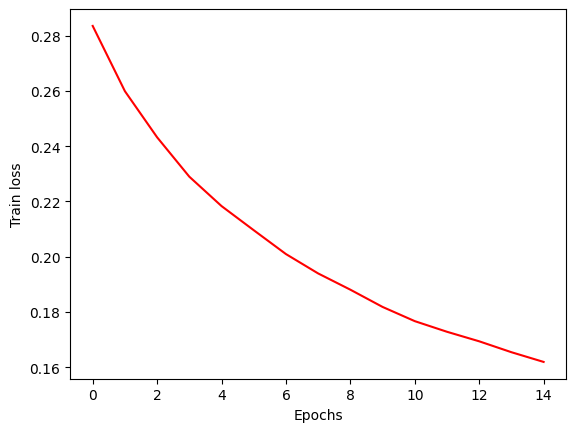

In [52]:
plt.plot(train_loss_score,color='red')
plt.xlabel("Epochs")
plt.ylabel("Train loss")
plt.show()

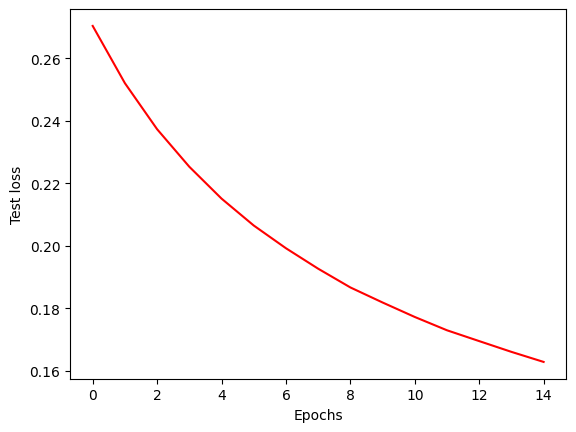

In [53]:
plt.plot(test_loss_score,color='red')
plt.xlabel("Epochs")
plt.ylabel("Test loss")
plt.show()

In [54]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

class_names = [
    "Bread", "Dairy product", "Dessert", "Egg", "Fried food",
    "Meat", "Noodles/Pasta", "Rice", "Seafood", "Soup", "Vegetable/Fruit"
]


num_classes = len(class_names)


softmax = nn.Softmax(dim=1)


all_true_labels = []
all_pred_labels = []

model2.eval()  


with torch.no_grad():  
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device) 
        labels = labels.to(device)  
        
        outputs = model2(inputs)
        
        predicted = softmax(outputs).argmax(dim=1)  
        
       
        all_true_labels.extend(labels.cpu().numpy())
        all_pred_labels.extend(predicted.cpu().numpy())


all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)


cm = confusion_matrix(all_true_labels, all_pred_labels, labels=np.arange(num_classes))
print("Confusion Matrix:")
print(cm)

# Compute precision, recall, and F1-score per class
precision = precision_score(all_true_labels, all_pred_labels, average=None, labels=np.arange(num_classes), zero_division=0)
recall = recall_score(all_true_labels, all_pred_labels, average=None, labels=np.arange(num_classes), zero_division=0)
f1 = f1_score(all_true_labels, all_pred_labels, average=None, labels=np.arange(num_classes), zero_division=0)


print("\nClass-wise Metrics:")
for i in range(num_classes):
    print(f"{class_names[i]:<15} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-score: {f1[i]:.4f}")

# Compute and print overall (weighted) metrics
precision_avg = precision_score(all_true_labels, all_pred_labels, average='weighted', labels=np.arange(num_classes), zero_division=0)
recall_avg = recall_score(all_true_labels, all_pred_labels, average='weighted', labels=np.arange(num_classes), zero_division=0)
f1_avg = f1_score(all_true_labels, all_pred_labels, average='weighted', labels=np.arange(num_classes), zero_division=0)

print("\nOverall Metrics:")
print(f"Average Precision: {precision_avg:.4f}")
print(f"Average Recall: {recall_avg:.4f}")
print(f"Average F1 Score: {f1_avg:.4f}")


Confusion Matrix:
[[199   0  31  41  37  40   0   0   3  15   2]
 [  5  19  78   6   6   7   0   0   6  15   6]
 [ 16   0 342  22  13  37   4   0  13  43  10]
 [ 41   2  28 190  15  33   4   1   5  14   2]
 [ 13   1  16   8 197  26   3   0   2  17   4]
 [  5   0  19   5  11 365   1   0   7  14   5]
 [  0   0   1   2   0   1 122   0   2  19   0]
 [  4   1   7   5   0   8   6  39   2  14  10]
 [  3   5  51   6   8  20   0   0 175  11  24]
 [  2   0  14   2   1   8   1   0   3 467   2]
 [  2   0  14   4   0   5   3   0   5   4 194]]

Class-wise Metrics:
Bread           - Precision: 0.6862, Recall: 0.5408, F1-score: 0.6049
Dairy product   - Precision: 0.6786, Recall: 0.1284, F1-score: 0.2159
Dessert         - Precision: 0.5691, Recall: 0.6840, F1-score: 0.6213
Egg             - Precision: 0.6529, Recall: 0.5672, F1-score: 0.6070
Fried food      - Precision: 0.6840, Recall: 0.6864, F1-score: 0.6852
Meat            - Precision: 0.6636, Recall: 0.8449, F1-score: 0.7434
Noodles/Pasta   - Preci